In [1]:
!conda list

# packages in environment at /vast/s224075134/miniconda3/envs/timegrad:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             5.1                       1_gnu  
aiohappyeyeballs          2.4.6                    pypi_0    pypi
aiohttp                   3.11.13                  pypi_0    pypi
aiosignal                 1.3.2                    pypi_0    pypi
annotated-types           0.7.0                    pypi_0    pypi
asttokens                 3.0.0                    pypi_0    pypi
attrs                     25.1.0                   pypi_0    pypi
bzip2                     1.0.8                h5eee18b_6  
ca-certificates           2024.12.31           h06a4308_0  
certifi                   2025.1.31                pypi_0    pypi
charset-normalizer        3.4.1                    pypi_0    pypi
comm                      0.2.2                    pypi_0    pypi
contourpy                

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from metrics import get_metrics
import torch

In [5]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [6]:
from pts.model.time_grad import TimeGradEstimator
from pytorch_lightning import Trainer

In [7]:
from diffusers import DEISMultistepScheduler

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [10]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

In [11]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset_electricity = get_dataset("electricity_nips", regenerate=False, prediction_length=15)

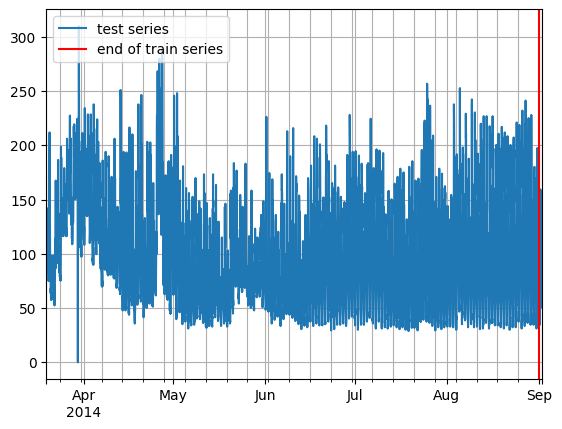

In [12]:
from gluonts.dataset.util import to_pandas
entry = next(iter(dataset_electricity.train))
train_series = to_pandas(entry)
#train_series.plot()
#plt.grid(which="both")
#plt.legend(["train series"], loc="upper left")
#plt.show()
entry = next(iter(dataset_electricity.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [26]:
for batch in dataset_electricity.test:
    test_series = to_pandas(batch)
    print(test_series.index[-1])

2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:

2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:00
2014-09-02 00:

In [17]:
test_series.loc[test_series.index > train_series.index[-1]].shape

(24,)

In [13]:
train_grouper_electricity = MultivariateGrouper(max_target_dim=min(2000, int(dataset_electricity.metadata.feat_static_cat[0].cardinality)))

test_grouper_electricity = MultivariateGrouper(num_test_dates=int(len(dataset_electricity.test)/len(dataset_electricity.train)), 
                                   max_target_dim=min(2000, int(dataset_electricity.metadata.feat_static_cat[0].cardinality)))

In [27]:
int(len(dataset_electricity.test)/len(dataset_electricity.train))

7

In [37]:
for i, batch in enumerate(dataset_electricity.test):
    print(batch['target'].shape)
    if i == 2:
        break

(4000,)
(4000,)
(4000,)


In [29]:
len(dataset_electricity.train)

370

In [14]:
dataset_train_electricity = train_grouper_electricity(dataset_electricity.train)
dataset_test_electricity = test_grouper_electricity(dataset_electricity.test)


In [15]:
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)

In [16]:
estimator = TimeGradEstimator(
    input_size=int(dataset_electricity.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=dataset_electricity.metadata.prediction_length,
    context_length=dataset_electricity.metadata.prediction_length * 3,
    freq=dataset_electricity.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=1, accelerator="gpu", devices="1"),
)


In [17]:
transformation = estimator.create_transformation()
trainnet = estimator.create_lightning_module()
trainnet.load_state_dict(torch.load('/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=18-step=950.ckpt')['state_dict'])
predictor=estimator.create_predictor(transformation, trainnet)

In [16]:
predictor_electricity = estimator_electricity.train(dataset_train_electricity, num_workers=8)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode  | In sizes                                                             | Out sizes        
-------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 432 K  | train | [[1, 1], [1, 1], [1, 72, 5], [1, 72, 370], [1, 72, 370], [1, 24, 5]] | [1, 100, 24, 370]
-------------------------------------------------------------------------------------------------------------------------------------------
432 K     Trainable params
0         Non-trainable params
432 K     Total params
1.729     Total estimated model params size (MB)


Epoch 0: |          | 50/? [02:00<00:00,  0.41it/s, v_num=3, train_loss=0.341]

Epoch 0, global step 50: 'train_loss' reached 0.34051 (best 0.34051), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:12<00:00,  3.92it/s, v_num=3, train_loss=0.0931]

Epoch 1, global step 100: 'train_loss' reached 0.09309 (best 0.09309), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:11<00:00,  4.17it/s, v_num=3, train_loss=0.0725]

Epoch 2, global step 150: 'train_loss' reached 0.07245 (best 0.07245), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:12<00:00,  3.91it/s, v_num=3, train_loss=0.0612]

Epoch 3, global step 200: 'train_loss' reached 0.06119 (best 0.06119), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:11<00:00,  4.49it/s, v_num=3, train_loss=0.055] 

Epoch 4, global step 250: 'train_loss' reached 0.05504 (best 0.05504), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:12<00:00,  4.07it/s, v_num=3, train_loss=0.0509]

Epoch 5, global step 300: 'train_loss' reached 0.05092 (best 0.05092), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:11<00:00,  4.45it/s, v_num=3, train_loss=0.0467]

Epoch 6, global step 350: 'train_loss' reached 0.04666 (best 0.04666), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:12<00:00,  4.14it/s, v_num=3, train_loss=0.0454]

Epoch 7, global step 400: 'train_loss' reached 0.04542 (best 0.04542), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:12<00:00,  4.04it/s, v_num=3, train_loss=0.0435]

Epoch 8, global step 450: 'train_loss' reached 0.04351 (best 0.04351), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:11<00:00,  4.53it/s, v_num=3, train_loss=0.0427]

Epoch 9, global step 500: 'train_loss' reached 0.04272 (best 0.04272), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:11<00:00,  4.21it/s, v_num=3, train_loss=0.0411]

Epoch 10, global step 550: 'train_loss' reached 0.04113 (best 0.04113), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:12<00:00,  4.13it/s, v_num=3, train_loss=0.0408]

Epoch 11, global step 600: 'train_loss' reached 0.04083 (best 0.04083), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:11<00:00,  4.24it/s, v_num=3, train_loss=0.0402]

Epoch 12, global step 650: 'train_loss' reached 0.04018 (best 0.04018), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:11<00:00,  4.24it/s, v_num=3, train_loss=0.0398]

Epoch 13, global step 700: 'train_loss' reached 0.03982 (best 0.03982), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:11<00:00,  4.41it/s, v_num=3, train_loss=0.040] 

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:11<00:00,  4.18it/s, v_num=3, train_loss=0.0383]

Epoch 15, global step 800: 'train_loss' reached 0.03829 (best 0.03829), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:12<00:00,  4.12it/s, v_num=3, train_loss=0.0381]

Epoch 16, global step 850: 'train_loss' reached 0.03806 (best 0.03806), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:12<00:00,  3.93it/s, v_num=3, train_loss=0.0379]

Epoch 17, global step 900: 'train_loss' reached 0.03793 (best 0.03793), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:12<00:00,  3.96it/s, v_num=3, train_loss=0.0375]

Epoch 18, global step 950: 'train_loss' reached 0.03754 (best 0.03754), saving model to '/vast/s224075134/timeseries/TimeGrad-re/pts7/lightning_logs/version_3/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:11<00:00,  4.34it/s, v_num=3, train_loss=0.0384]

Epoch 19, global step 1000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: |          | 50/? [00:11<00:00,  4.31it/s, v_num=3, train_loss=0.0384]


In [20]:
predictor.prediction_net.model.context_length

69

In [30]:
from gluonts.dataset.split import split

window_length = predictor.prediction_length
_, test_template = split(dataset_test_electricity, offset=-34)
#windows: number of generated sample
#distance: stride
test_data = test_template.generate_instances(
        prediction_length=9, 
        #windows=10,
        distance=2
    )

for i, data in enumerate(test_data):
    print(data[0]['target'].shape,'\n\n')
    if i == 3:
        break

(370, 3966) 


(370, 3990) 


(370, 4014) 


(370, 4038) 




In [67]:
test_data.input

InputDataset(test_data=TestData(dataset=[{'target': array([[141.70506 , 141.12903 , 119.81567 , ...,  71.42857 ,  58.75576 ,
         50.691246],
       [153.19148 , 183.51064 , 153.7234  , ..., 155.31915 , 138.29787 ,
        115.42553 ],
       [ 67.242355,  67.80861 ,  77.57645 , ...,  69.648926,  50.537937,
         45.7248  ],
       ...,
       [157.96083 , 174.87328 , 192.54993 , ..., 147.2043  , 111.4593  ,
        121.831795],
       [255.66438 , 269.4007  , 293.10275 , ..., 249.82535 , 149.88014 ,
        145.42465 ],
       [ 90.4176  ,  91.34974 ,  89.858315, ...,  97.50186 ,  70.84265 ,
         66.18195 ]], dtype=float32), 'start': Period('2014-03-19 09:00', 'H'), 'feat_static_cat': array([0], dtype=int32)}, {'target': array([[  0.      ,   0.      ,   0.      , ...,  65.09216 ,  58.75576 ,
         48.387096],
       [  0.      ,   0.      ,   0.      , ..., 144.68085 , 140.95744 ,
        125.53191 ],
       [  0.      ,   0.      ,   0.      , ...,  71.77237 ,  56.3420

In [15]:
forecast_it_electricity, ts_it_electricity = make_evaluation_predictions(dataset=dataset_test_electricity,
                                                 predictor=predictor,
                                                 num_samples=50)


In [16]:
forecasts_electricity = list(forecast_it_electricity)
targets_electricity = list(ts_it_electricity)

Electricity


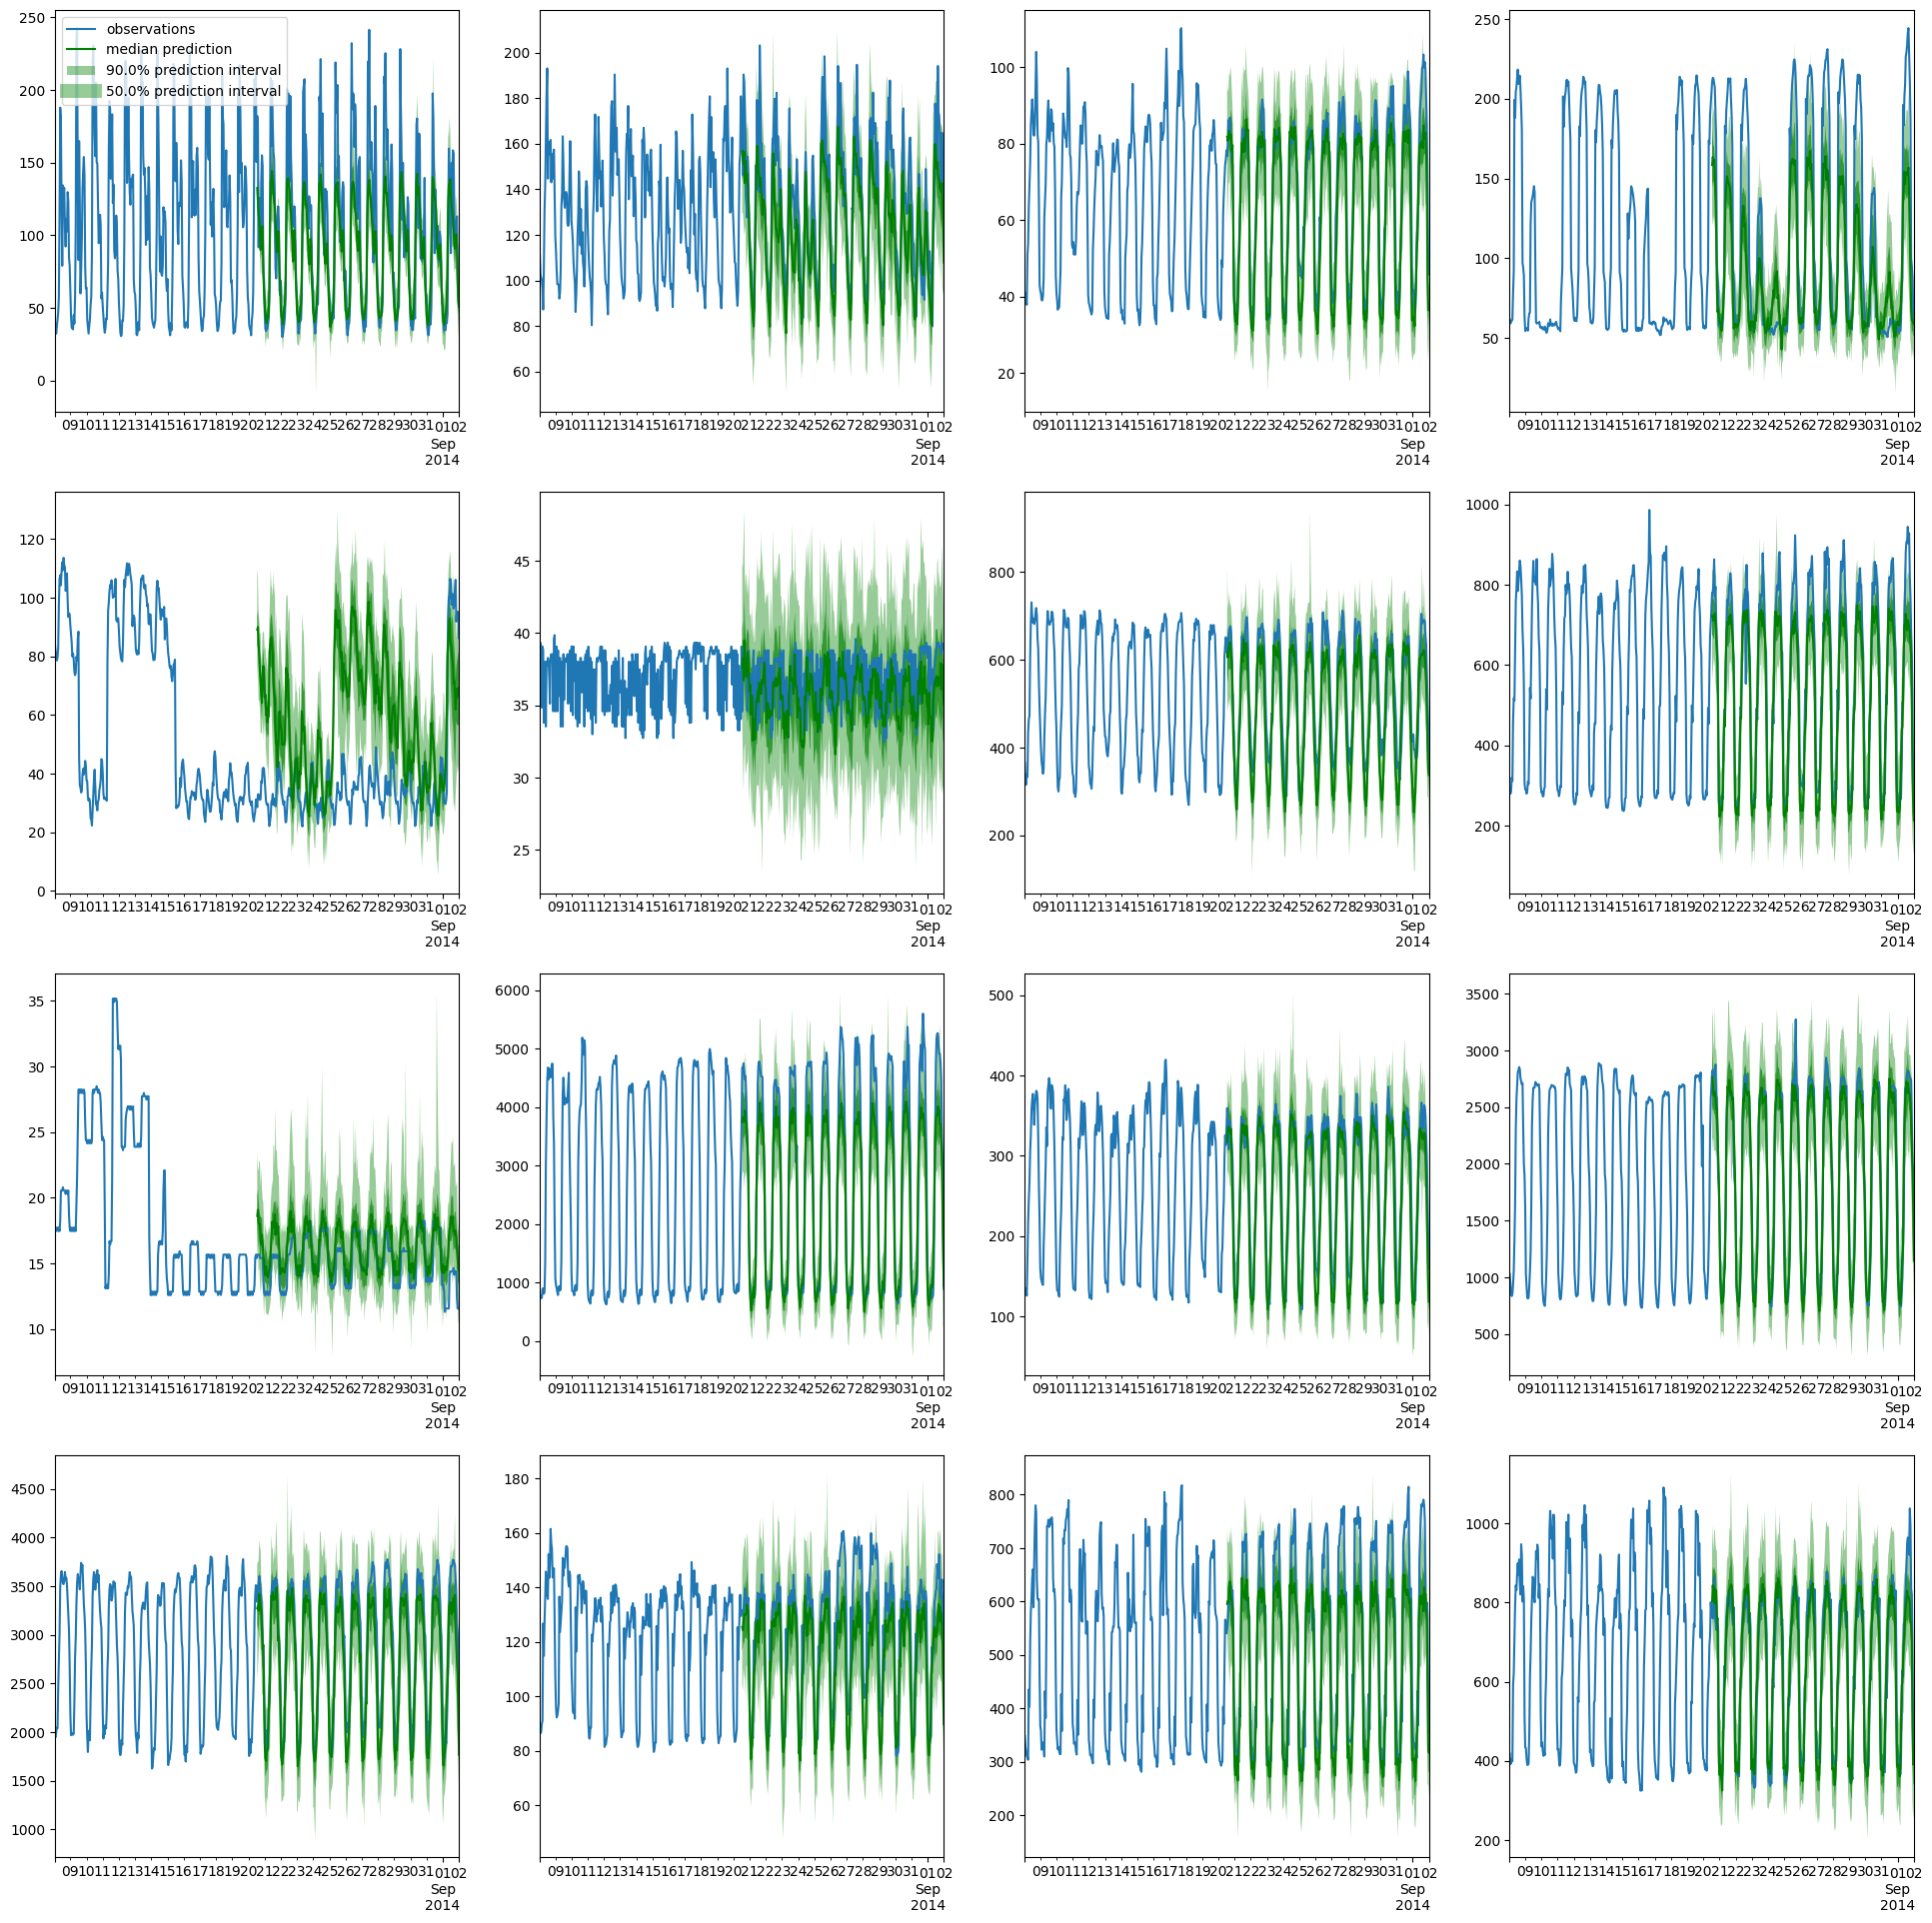

In [17]:
print("Electricity")

plot(
    target=targets_electricity[0],
    forecast=forecasts_electricity[0],
    prediction_length=dataset_electricity.metadata.prediction_length,
)
plt.show()

In [20]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [21]:
def quantile_loss(target, forecast, q: float, eval_points) -> float:
    return 2 * torch.sum(
        torch.abs((forecast - target) * eval_points * ((target <= forecast) * 1.0 - q))
    )


def calc_denominator(target, eval_points):
    return torch.sum(torch.abs(target * eval_points))


def calc_quantile_CRPS(target, forecast, eval_points, mean_scaler, scaler):

    target = target * scaler + mean_scaler
    forecast = forecast * scaler + mean_scaler

    quantiles = np.arange(0.05, 1.0, 0.05)
    denom = calc_denominator(target, eval_points)
    CRPS = 0
    for i in range(len(quantiles)):
        q_pred = []
        for j in range(len(forecast)):
            q_pred.append(torch.quantile(forecast[j : j + 1], quantiles[i], dim=1))
        q_pred = torch.cat(q_pred, 0)
        q_loss = quantile_loss(target, q_pred, quantiles[i], eval_points)
        CRPS += q_loss / denom
    return CRPS.item() / len(quantiles)

def calc_quantile_CRPS_sum(target, forecast, eval_points, mean_scaler, scaler):

    eval_points = eval_points.mean(-1)
    target = target * scaler + mean_scaler
    target = target.sum(-1)
    forecast = forecast * scaler + mean_scaler

    quantiles = np.arange(0.05, 1.0, 0.05)
    denom = calc_denominator(target, eval_points)
    CRPS = 0
    for i in range(len(quantiles)):
        q_pred = torch.quantile(forecast.sum(-1),quantiles[i],dim=1)
        q_loss = quantile_loss(target, q_pred, quantiles[i], eval_points)
        CRPS += q_loss / denom
    return CRPS.item() / len(quantiles)

In [22]:
targets = []
preds = []
for i in range(len(targets_electricity)):
    targets.append(torch.tensor(np.atleast_1d(np.squeeze(targets_electricity[i].loc[forecasts_electricity[i].index]))))
    preds.append(torch.tensor(forecasts_electricity[i].samples))

targets = torch.stack(targets)
preds = torch.stack(preds)

In [23]:
metrics = get_metrics(preds, targets)

In [24]:
metrics[0]

array([1.16070335e-01,            inf, 9.66011350e-02, 7.81521850e-02,
       4.73226389e-02, 2.81818375e+05])

In [25]:
agg_metric_electricity, item_metrics_electricity = evaluator(targets_electricity, forecasts_electricity, num_series=len(dataset_test_electricity))


Running evaluation: 7it [00:00, 77.86it/s]
Running evaluation: 7it [00:00, 109.29it/s]
Running evaluation: 7it [00:00, 112.15it/s]
Running evaluation: 0it [00:00, ?it/s]

Running evaluation: 7it [00:00, 112.64it/s]
Running evaluation: 7it [00:00, 111.58it/s]
Running evaluation: 7it [00:00, 112.44it/s]
Running evaluation: 7it [00:00, 105.48it/s]
Running evaluation: 7it [00:00, 111.27it/s]
Running evaluation: 7it [00:00, 111.02it/s]
Running evaluation: 7it [00:00, 109.13it/s]
Running evaluation: 7it [00:00, 112.10it/s]
Running evaluation: 7it [00:00, 112.20it/s]
Running evaluation: 7it [00:00, 110.04it/s]
Running evaluation: 7it [00:00, 112.67it/s]
Running evaluation: 7it [00:00, 111.74it/s]
Running evaluation: 7it [00:00, 108.95it/s]
Running evaluation: 7it [00:00, 111.43it/s]
Running evaluation: 7it [00:00, 111.38it/s]
Running evaluation: 7it [00:00, 106.37it/s]
Running evaluation: 7it [00:00, 112.12it/s]
Running evaluation: 7it [00:00, 112.37it/s]
Running evaluation: 7it [00:00, 112.64it/s]
Running evaluation: 7it [00:00, 111.74it/s]
Running evaluation: 7it [00:00, 112.32it/s]
Running evaluation: 7it [00:00, 111.13it/s]
Running evaluation: 7it [00:00, 

In [32]:
type(forecasts_electricity[0].samples)

numpy.ndarray

In [26]:
print("Electricity Results")
print("CRPS:", agg_metric_electricity["mean_wQuantileLoss"])
print("ND:", agg_metric_electricity["ND"])
print("NRMSE:", agg_metric_electricity["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric_electricity["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric_electricity["m_sum_ND"])
print("NRMSE-Sum:", agg_metric_electricity["m_sum_NRMSE"])

Electricity Results
CRPS: 0.12142596246422019
ND: 0.15822727246770962
NRMSE: 1.5806689108099077

CRPS-Sum: 0.10100382745724978
ND-Sum: 0.12530548572988415
NRMSE-Sum: 0.15193255177918707


In [22]:
import numpy as np
from typing import List
import numpy as np
import torch
from pyro.ops.stats import crps_empirical

def eval_crps_mean(preds, labels):
    """
    preds: (n_sample, N, Q)
    labels: (N, Q)
    """
    crps = crps_empirical(preds, labels)  # (N, Q)
    crps /= labels.abs().mean()
    return crps.mean().item(), crps


def eval_crps(preds, labels):
    """
    preds: (n_sample, N, Q)
    labels: (N, Q)
    """
    crps = crps_empirical(preds, labels)
    crps /= labels.abs().mean(-1, keepdim=True)
    return crps.mean().item(), crps


def eval_crps_sum(preds, labels):
    """
    preds: (n_sample, N, Q)
    labels: (N, Q)
    """
    preds_sum = preds.sum(-2)
    labels_sum = labels.sum(-2)
    crps_sum = crps_empirical(preds_sum, labels_sum)  # (Q,)
    crps_sum /= labels_sum.abs().mean()
    return crps_sum.mean().item(), crps_sum


def eval_energy_score(preds, labels, beta=1.0):
    """
    preds: (n_sample, N, Q)
    labels: (N, Q)
    """
    assert 0 < beta < 2
    num_samples = preds.shape[0]
    # The Frobenius norm of a matrix is equal to the Euclidean norm of its element:
    # the square root of the sum of the square of its elements
    norm = torch.linalg.norm(preds - labels[None, :, :], ord="fro", dim=(1, 2))
    first_term = (norm**beta).mean()

    # For the second term of the energy score, we need two independant realizations of the distributions.
    # So we do a sum ignoring the i == j terms (which would be zero anyway), and we normalize by the
    # number of pairs of samples we have summed over.
    s = torch.tensor(0.0)
    for i in range(num_samples - 1):
        for j in range(i + 1, num_samples):
            norm = torch.linalg.norm(preds[i] - preds[j], ord="fro")
            s += norm**beta
    second_term = s / (num_samples * (num_samples - 1) / 2)

    return first_term - 0.5 * second_term


class QuantileLoss():
    def __init__(self, quantiles: List[float] = [0.1, 0.25, 0.5, 0.75, 0.9]):
        super().__init__()
        self.quantiles = quantiles

    def loss(self, y_pred: torch.Tensor, target: torch.Tensor):
        quantiles = torch.quantile(y_pred, torch.tensor(self.quantiles, device=y_pred.device), dim=-1)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - quantiles[i]
            losses.append(torch.max((q-1)*errors, q*errors))
        return losses
    

def get_metrics_feature_dim_before_temporal(preds, labels):
    """
    preds: (n_frcs, N, Q, n_sample)
    labels: (n_frcs, N, Q)
    
    pred permute: (n_sample, N, Q)
    pred: (N, Q, n_sample)
    label: (N, Q)
    
    n_frcs: number of evaluation => average over n_frcs
    N: feature dim
    Q: temporal dim
    """
    ql = QuantileLoss(quantiles=[0.5, 0.9])
    n_frcs = labels.shape[0]
    acc_metrics = []
    crps_mean_noagg_all, crps_noagg_all, crps_sum_noagg_all = [], [], []
    for i in range(n_frcs):
        crps_mean, crps_mean_noagg = eval_crps_mean(preds[i].permute(2, 0, 1), labels[i])
        crps, crps_noagg = eval_crps(preds[i].permute(2, 0, 1), labels[i])
        crps_sum, crps_sum_noagg = eval_crps_sum(preds[i].permute(2, 0, 1), labels[i])

        crps_mean_noagg_all.append(crps_mean_noagg)
        crps_noagg_all.append(crps_noagg)
        crps_sum_noagg_all.append(crps_sum_noagg)
        
        es = eval_energy_score(preds[i].permute(2, 0, 1), labels[i]).item()

        ql05, ql09 = ql.loss(preds[i], labels[i])
        p05_risk = (ql05.sum()/labels[i].sum()).item()
        p09_risk = (ql09.sum()/labels[i].sum()).item()

        acc_metrics.append([crps_mean, crps, crps_sum, p05_risk, p09_risk, es])

    crps_mean_noagg = torch.stack(crps_mean_noagg_all)
    crps_noagg = torch.stack(crps_noagg_all)
    crps_sum_noagg = torch.stack(crps_sum_noagg_all)

    return np.array(acc_metrics).sum(0) / n_frcs, crps_mean_noagg, crps_noagg, crps_sum_noagg

def get_metrics(preds, labels):
    """
    preds: (n_frcs, n_sample, T, F)
    labels: (n_frcs, T, F)

    will be reshaped to:
    - preds: (n_frcs, F, T, n_sample)
    - labels: (n_frcs, F, T)

    n_frcs: number of evaluation => average over n_frcs
    n_sample: number of samples
    T: temporal dim
    F: feature dim
    """

    preds = preds.permute(0, 3, 2, 1)
    labels = labels.permute(0, 2, 1)
    return get_metrics_feature_dim_before_temporal(preds, labels)

In [ ]:
targets = torch.stack(targ)

7